In [5]:
!pip install pybit
!pip install qgrid

     |████████████████████████████████| 889 kB 11.7 MB/s 
  Created wheel for qgrid: filename=qgrid-1.3.1-py2.py3-none-any.whl size=1761272 sha256=7c92d823ba7a4de9bbb33b9dab8bdd9d214cd64207e5830b2b5f3ce019fb30bf
  Stored in directory: /root/.cache/pip/wheels/53/87/cb/c63a58774627471976061afb5b8657b76d2268c1e76e980586
Successfully built qgrid


In [76]:
import requests 
import json 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import qgrid
import time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import numpy as np

In [103]:
def get_binance_bars(symbol, interval, startTime, endTime):
 
    url = "https://api.binance.com/api/v3/klines"
 
    startTime = str(int(startTime.timestamp() * 1000))
    endTime = str(int(endTime.timestamp() * 1000))
    limit = '1000'
 
    req_params = {"symbol" : symbol, 'interval' : interval, 'startTime' : startTime, 'endTime' : endTime, 'limit' : limit}
 
    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text))
 
    if (len(df.index) == 0):
        return None
     
    df = df.iloc[:, 0:6]
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
 
    df.open      = df.open.astype("float")
    df.high      = df.high.astype("float")
    df.low       = df.low.astype("float")
    df.close     = df.close.astype("float")
    df.volume    = df.volume.astype("float")
    
    df['adj_close'] = df['close']
     
    df.index = [dt.datetime.fromtimestamp(x / 1000.0) for x in df.datetime]
 
    return df

In [203]:
data = get_binance_bars('ETHUSDT', '5m', dt.datetime(2022, 1, 24), dt.datetime(2022, 1, 28))

In [204]:
data

,datetime,open,high,low,close,volume,adj_close
2022-01-24 00:00:00,1642982400000,2539.00,2539.75,2526.17,2527.06,3400.1425,2527.06
2022-01-24 00:05:00,1642982700000,2526.77,2529.00,2509.61,2517.26,3539.0881,2517.26
2022-01-24 00:10:00,1642983000000,2517.26,2520.86,2511.95,2515.94,2875.3105,2515.94
2022-01-24 00:15:00,1642983300000,2515.94,2523.74,2513.81,2515.21,2761.9444,2515.21
2022-01-24 00:20:00,1642983600000,2515.20,2518.16,2485.61,2501.12,6030.2682,2501.12
...,...,...,...,...,...,...,...
2022-01-27 10:55:00,1643280900000,2422.88,2426.49,2419.40,2424.37,1055.3091,2424.37
2022-01-27 11:00:00,1643281200000,2424.37,2431.93,2423.11,2426.10,1351.2774,2426.10
2022-01-27 11:05:00,1643281500000,2426.10,2432.24,2425.95,2431.74,563.7824,2431.74
2022-01-27 11:10:00,1643281800000,2431.75,2437.33,2431.36,2435.89,917.8453,2435.89


In [205]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))

In [206]:
scaled_data.shape

(1000, 1)

In [207]:
time_intervals_to_train = 24
prediction_interval = 12

x_train = []
y_train = []

In [208]:
for i in range(time_intervals_to_train, len(scaled_data)-prediction_interval):
  x_train.append(scaled_data[i - time_intervals_to_train: i,0])
  y_train.append(scaled_data[i + prediction_interval, 0])
x_train = np.array(x_train)
y_train = np.array(y_train)

In [209]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [210]:
x_train.shape

(964, 24, 1)

In [211]:
model = Sequential()
model.add(LSTM(128,return_sequences=True, input_shape = (x_train.shape[1],1),activation = "relu"))

In [212]:
model.add(Dropout(0.4))
model.add(LSTM(64,return_sequences=True, activation = 'relu'))
model.add(Dropout(0.3))
model.add(LSTM(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [213]:
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics = ['accuracy'])

In [214]:
model.fit(x_train,y_train,epochs=10,batch_size=64)

Epoch 1/10
16/16 [==============================] - 4s 58ms/step - loss: 0.0266 - accuracy: 0.0021
Epoch 2/10
16/16 [==============================] - 1s 57ms/step - loss: 0.0173 - accuracy: 0.0021
Epoch 3/10
16/16 [==============================] - 1s 58ms/step - loss: 0.0117 - accuracy: 0.0021
Epoch 4/10
16/16 [==============================] - 1s 58ms/step - loss: 0.0102 - accuracy: 0.0021
Epoch 5/10
16/16 [==============================] - 1s 57ms/step - loss: 0.0099 - accuracy: 0.0021
Epoch 6/10
16/16 [==============================] - 1s 57ms/step - loss: 0.0089 - accuracy: 0.0021
Epoch 7/10
16/16 [==============================] - 1s 58ms/step - loss: 0.0100 - accuracy: 0.0021
Epoch 8/10
16/16 [==============================] - 1s 58ms/step - loss: 0.0090 - accuracy: 0.0021
Epoch 9/10
16/16 [==============================] - 1s 59ms/step - loss: 0.0082 - accuracy: 0.0021
Epoch 10/10
16/16 [==============================] - 1s 60ms/step - loss: 0.0084 - accuracy: 0.0021


In [215]:
test_data = get_binance_bars('ETHUSDT', '5m', dt.datetime(2022, 1, 29), dt.datetime(2022, 2, 2))

In [216]:
eth_price = pd.to_numeric(test_data['close'],errors='coerce').values
test_inputs = test_data['close'].values
test_inputs = test_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(test_inputs)

In [217]:
model_inputs.shape

(903, 1)

In [218]:
x_test = []
for x in range(time_intervals_to_train, len(model_inputs)):
  x_test.append(model_inputs[x - time_intervals_to_train:x, 0])

x_test = np.array(x_test)


In [219]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [235]:
x_test

array([[[0.2538715 ],
        [0.29411038],
        [0.33369028],
        ...,
        [0.16445634],
        [0.17055189],
        [0.17055189]],

       [[0.29411038],
        [0.33369028],
        [0.34390445],
        ...,
        [0.17055189],
        [0.17055189],
        [0.18414333]],

       [[0.33369028],
        [0.34390445],
        [0.36882208],
        ...,
        [0.17055189],
        [0.18414333],
        [0.19897035]],

       ...,

       [[0.83327842],
        [0.85737232],
        [0.85778418],
        ...,
        [0.88237232],
        [0.89991763],
        [0.92462932]],

       [[0.85737232],
        [0.85778418],
        [0.85300659],
        ...,
        [0.89991763],
        [0.92462932],
        [0.90766063]],

       [[0.85778418],
        [0.85300659],
        [0.8407743 ],
        ...,
        [0.92462932],
        [0.90766063],
        [1.        ]]])

In [220]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

In [221]:
prediction_prices

array([[2562.4443],
       [2560.504 ],
       [2558.527 ],
       [2556.6006],
       [2554.848 ],
       [2553.2913],
       [2551.909 ],
       [2550.5972],
       [2549.3152],
       [2548.057 ],
       [2546.7966],
       [2545.5613],
       [2544.3992],
       [2543.319 ],
       [2542.3313],
       [2541.4927],
       [2540.8467],
       [2540.3762],
       [2540.0762],
       [2539.9004],
       [2539.8052],
       [2539.8455],
       [2539.9817],
       [2540.212 ],
       [2540.5574],
       [2541.0068],
       [2541.603 ],
       [2542.3555],
       [2543.2659],
       [2544.3025],
       [2545.4104],
       [2546.5205],
       [2547.5454],
       [2548.479 ],
       [2549.3171],
       [2550.0183],
       [2550.5688],
       [2550.9695],
       [2551.2139],
       [2551.2883],
       [2551.192 ],
       [2550.9019],
       [2550.4497],
       [2549.8652],
       [2549.2048],
       [2548.4138],
       [2547.5098],
       [2546.5745],
       [2545.6426],
       [2544.7686],


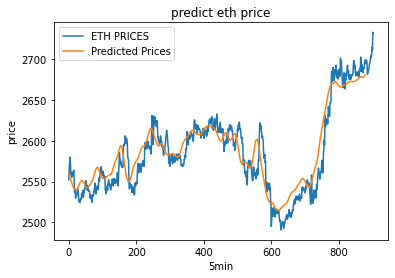

In [222]:
plt.plot(eth_price,label = "ETH PRICES")
plt.plot(prediction_prices,label="Predicted Prices")
plt.title("predict eth price")
plt.xlabel("5min")
plt.ylabel('price')
plt.legend()
plt.show()

In [260]:
last_data = model_inputs[len(model_inputs)+1 - time_intervals_to_train: len(model_inputs)+1,0]
last_data = np.array(last_data)

In [261]:
last_data

array([0.8407743 , 0.85980231, 0.85770181, 0.85807249, 0.83521417,
       0.7871911 , 0.792257  , 0.79884679, 0.80687809, 0.80873147,
       0.82100494, 0.84085667, 0.84110379, 0.84859967, 0.86272652,
       0.88060132, 0.87034596, 0.88237232, 0.89991763, 0.92462932,
       0.90766063, 1.        , 0.99415157])

In [270]:
last_data.shape

(23, 1)

In [271]:
last_data = np.reshape(last_data, (last_data.shape[0],1))

In [264]:
last_data.shape

(23, 1)

In [265]:
prediction = model.predict(last_data)


In [267]:
prediction = scaler.inverse_transform(prediction)

In [268]:
prediction

array([[2608.707 ],
       [2608.7173],
       [2608.716 ],
       [2608.7163],
       [2608.7039],
       [2608.678 ],
       [2608.681 ],
       [2608.6843],
       [2608.6887],
       [2608.6897],
       [2608.696 ],
       [2608.707 ],
       [2608.7073],
       [2608.7112],
       [2608.7188],
       [2608.7285],
       [2608.723 ],
       [2608.7295],
       [2608.7393],
       [2608.7534],
       [2608.7437],
       [2608.7983],
       [2608.795 ]], dtype=float32)

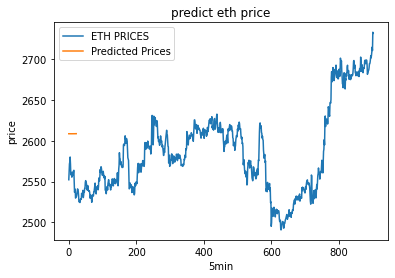